# Bills Pass
This project aims to predict if a bill will pass by its text content alone.

## The Data
Data obtained from the openstates api, using getBills.py. Saved into gaBills#.csv

In [1]:
# csv has big text; allow it
import sys
import csv

csv.field_size_limit(sys.maxsize)

files = ["gaBills0.csv", "gaBills1.csv", "gaBills2.csv", "gaBills3.csv"]
bills = []
for f in files:
    with open(f, "r", newline='')  as inputFile:
        bills += list(csv.DictReader(inputFile))

# how many bills do we have to work with? 
print(len(bills))        

1222


Let's look at a bill.

In [2]:
print(bills[222])

OrderedDict([('status', 'Effective Date'), ('passDate', '2020-06-22'), ('text', 'HB 894/AP H. B. 894- 1 -House Bill 894 (AS PASSED HOUSE AND SENATE)By: Representatives Meeks of the 178 th, McCall of the 33 rd, Corbett of the 174 th, Houston ofthe 170th, Pirkle of the 155th, and others A BILL TO BE ENTITLEDAN ACTTo amend Code Section 2-4-3 of the Official Code of Georgia Annotated, relating to Seed1Development Commission composition, officers, bylaws, quorum, compensation, records, audit, and bonds, so as to stagger the terms  of commission members; to provide for related matters; to provide for an effective date; to repeal conflicting laws; and for other purposes. BE IT ENACTED BY THE GENERAL ASSEMBLY OF GEORGIA:5SECTION 1.6Code Section 2-4-3 of the Official Code of Georgia Annotated, relating to Seed Development Commission composition, officers, bylaws, quorum, compensation, records, audit, and bonds, is amended by revising subsections (b) and (c) as follows: (b)  The commission shall

For now, I only care about if a bill has passed, so let's do some cleaning/preparation.

In [3]:
def prepareBill(bill):
    del bill["status"]
    if bill["passDate"]:
        bill["passed"] = 1
    else:
        bill["passed"] = 0
    del bill["passDate"]
    return bill

cleanedBills = [x for x in map(prepareBill, bills)]
print(cleanedBills[222])


OrderedDict([('text', 'HB 894/AP H. B. 894- 1 -House Bill 894 (AS PASSED HOUSE AND SENATE)By: Representatives Meeks of the 178 th, McCall of the 33 rd, Corbett of the 174 th, Houston ofthe 170th, Pirkle of the 155th, and others A BILL TO BE ENTITLEDAN ACTTo amend Code Section 2-4-3 of the Official Code of Georgia Annotated, relating to Seed1Development Commission composition, officers, bylaws, quorum, compensation, records, audit, and bonds, so as to stagger the terms  of commission members; to provide for related matters; to provide for an effective date; to repeal conflicting laws; and for other purposes. BE IT ENACTED BY THE GENERAL ASSEMBLY OF GEORGIA:5SECTION 1.6Code Section 2-4-3 of the Official Code of Georgia Annotated, relating to Seed Development Commission composition, officers, bylaws, quorum, compensation, records, audit, and bonds, is amended by revising subsections (b) and (c) as follows: (b)  The commission shall be composed of the following 11 members: (1)(A)  Two memb

How many bills have been passed, though?

In [4]:
print(len([x for x in cleanedBills if x['passed'] == 1]))

949


That's higher than I expected. Let's move onto...

## The Model

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random, math

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

/home/ryan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ryan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ryan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ryan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

It's shuffle time!

In [6]:
random.shuffle(cleanedBills)
splitNum = int(math.floor(len(cleanedBills)*0.1))
testData = cleanedBills[:splitNum]
trainData = cleanedBills[splitNum:]
print("Training Examples: " + str(len(trainData)) + " Test Examples: " + str(len(testData)))

Training Examples: 1100 Test Examples: 122


In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts([x['text'] for x in trainData])
tokenizer.fit_on_texts([x['text'] for x in testData])
X_train = tokenizer.texts_to_sequences([x['text'] for x in trainData])
X_test = tokenizer.texts_to_sequences([x['text'] for x in testData])
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding="post", maxlen=20)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding="post", maxlen=20)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['binary_accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          160000    
_________________________________________________________________
bidirectional (Bidirectional (No

In [9]:
Y_train = [float(x['passed']) for x in trainData]
Y_test = [float(y['passed']) for y in testData]
h = model.fit(x=X_train, y=np.asarray(Y_train), epochs=100)

Epoch 1/100
1100/1100 [==============================] - 1s 1ms/sample - loss: 0.6871 - binary_accuracy: 0.7518
Epoch 2/100
1100/1100 [==============================] - 1s 506us/sample - loss: 0.6738 - binary_accuracy: 0.7791
Epoch 3/100
1100/1100 [==============================] - 1s 461us/sample - loss: 0.6555 - binary_accuracy: 0.7791
Epoch 4/100
1100/1100 [==============================] - 1s 476us/sample - loss: 0.6315 - binary_accuracy: 0.7791
Epoch 5/100
1100/1100 [==============================] - 1s 476us/sample - loss: 0.6009 - binary_accuracy: 0.7791
Epoch 6/100
1100/1100 [==============================] - 1s 575us/sample - loss: 0.5618 - binary_accuracy: 0.7791
Epoch 7/100
1100/1100 [==============================] - 1s 587us/sample - loss: 0.5177 - binary_accuracy: 0.7791
Epoch 8/100
1100/1100 [==============================] - 1s 519us/sample - loss: 0.4844 - binary_accuracy: 0.7791
Epoch 9/100
1100/1100 [==============================] - 1s 539us/sample - loss: 0.4668 - 

KeyError: 'val_loss'

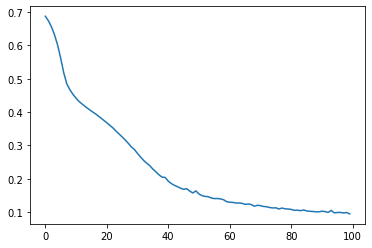

In [10]:

plot_graphs(h, 'loss')

## Evaluation

In [11]:
predictions = model.predict(x=X_test)
score = model.evaluate(X_test, np.asarray(Y_test))

122/122 [==============================] - 0s 923us/sample - loss: 0.5540 - binary_accuracy: 0.8525


I'm not convinced that this is a good result, as "always passes" would get accuracy of about 0.77. Maybe I'll revisit later.